In [268]:
import pandas as pd 
import wandb
from collections import defaultdict
import json

api = wandb.Api()
entity, project = "itl", "hog"  # set to your entity and project 
runs = api.runs(entity + "/" + project) 
df_dict = defaultdict(list)

stats_keys = {"test_accuracy": "Accuracy/test_average_accuracy", 
              "test_diff_accuracy": "Accuracy/test_diff_accuracy"}


table_names = {"Attribute Errors/test_attribute_level_error_rate_table": "test_attribute_errors"}
tables_paths = defaultdict(list)
for run in runs: 
    if "nlu" not in run.name:
        continue
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files
    # summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    # config_list.append(
    #     {k: v for k,v in run.config.items()
    #      if not k.startswith('_')})

    # .name is the human-readable name of the run.

    df_dict["name"].append(run.name)

    summary = run.summary._json_dict
    for key, value in stats_keys.items():
        if value in summary:
            df_dict[key].append(summary[value])
        else:
            df_dict[key].append(None)
    
    for table_name, table_name_clean in table_names.items():
        path = run.summary._json_dict["Attribute Errors/test_attribute_level_error_rate_table"]["path"]
        run.file(path).download(replace=True)
        tables_paths[table_name_clean].append({run.name: path})

runs_df = pd.DataFrame(df_dict)

In [267]:
test_run.summary._json_dict["Confusion Matrices/test_size_table"]

{'ncols': 3,
 'nrows': 64,
 'sha256': 'cc97ad60dc33cc62a40bdfc7bf5ccf208f0a4dbc215569aced76feeb14fe5abb',
 'artifact_path': 'wandb-client-artifact://nh3hqfowmhhkvcojmoxs6sfenzn9gq2ththolbmtbafj99nxuuhqck55dbx963h4fhpsykksq4mvhp0w6z1a9je9sd81dztd4xhzhpf3eezr5xxutqka1d48jintn861:latest/Confusion Matrices/test_size_table.table.json',
 '_latest_artifact_path': 'wandb-client-artifact://nh3hqfowmhhkvcojmoxs6sfenzn9gq2ththolbmtbafj99nxuuhqck55dbx963h4fhpsykksq4mvhp0w6z1a9je9sd81dztd4xhzhpf3eezr5xxutqka1d48jintn861:latest/Confusion Matrices/test_size_table.table.json',
 'path': 'media/table/Confusion Matrices/test_size_table_3091_cc97ad60dc33cc62a40b.table.json',
 'size': 905,
 '_type': 'table-file'}

# Plot attributes

In [254]:
for name, path in tables_paths["test_attribute_errors"]:
    with open(path, "r") as file:
        print(path)
        table_data = json.load(file)        
    data += table_data["data"]
    names += [name]*len(table_data["data"])

df = pd.DataFrame(data, columns=table_data["columns"])
df["name"] = names

names = {"images_fuse_256_42_nlu": "Images", "piglet_42_nlu": "Symbolic", "piglet_no_symbolic_42_nlu": "No Symbolic/Images"}
keys = list(names.keys())
df["name"] = df.name.map(names, na_action="ignore")
df = df[df.name.isin(list(names.values()))]

media/table/Attribute Errors/test_attribute_level_error_rate_table_3097_9be458c84e6f6ae7654a.table.json
media/table/Attribute Errors/test_attribute_level_error_rate_table_3016_739341ae8c7e192e1111.table.json
media/table/Attribute Errors/test_attribute_level_error_rate_table_3016_210b9e3e2a9fbd060db8.table.json
media/table/Attribute Errors/test_attribute_level_error_rate_table_3088_a2c4285ba0dec30dc87e.table.json
media/table/Attribute Errors/test_attribute_level_error_rate_table_3088_8f396d27a9f863429648.table.json


In [255]:
df = df[df.attribute.isin(df.sort_values("error_rate", ascending=False).attribute.unique()[:5])]

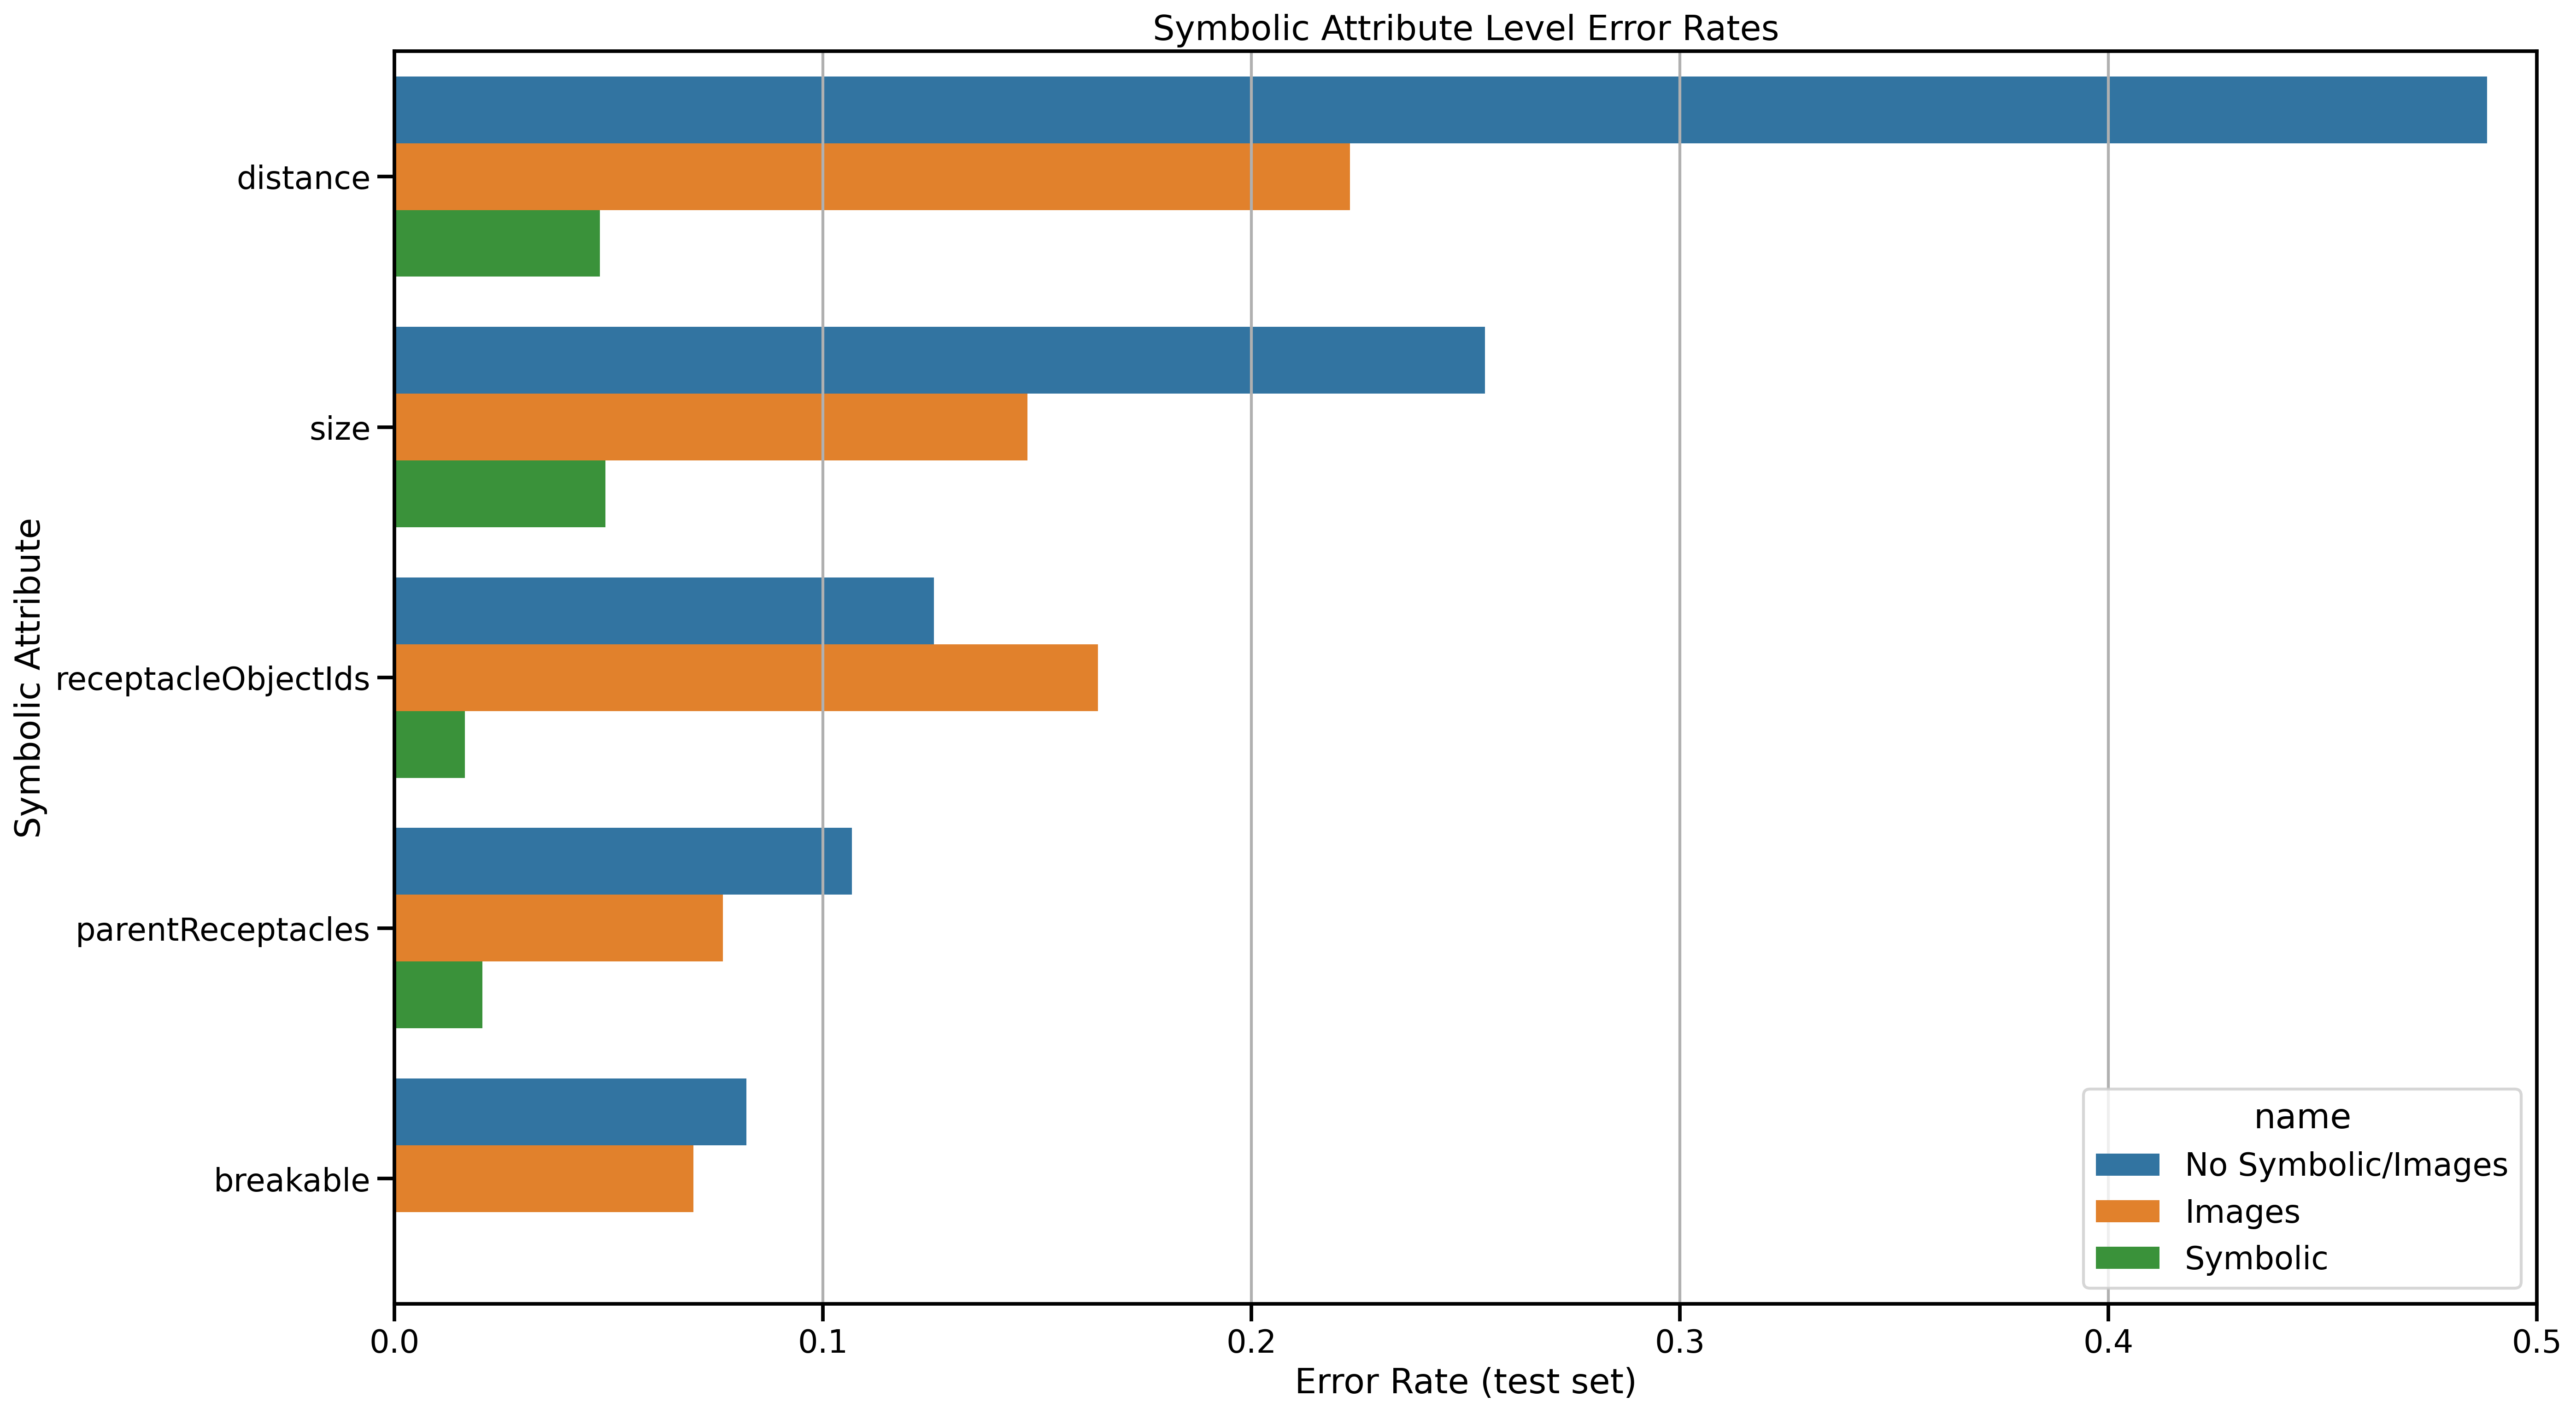

In [262]:
plt.figure(figsize=(20, 12), dpi=300)
sns.barplot(data=df.sort_values("error_rate", ascending=False), y="attribute", x="error_rate", hue="name")
plt.ylabel("Symbolic Attribute")
plt.xlabel("Error Rate (test set)")
plt.grid(axis="x")
plt.xlim(0, 0.5)
plt.title("Symbolic Attribute Level Error Rates")
plt.savefig("att_errs.png", dpi=300)
plt.show()

# Plot metrics

In [165]:
names = {"images_fuse_256_42_nlu": "Images", "piglet_42_nlu": "Symbolic", "piglet_no_symbolic_42_nlu": "No Symbolic/Images"}
keys = list(names.keys())

runs_df["name"] = runs_df.name.map(names, na_action="ignore")

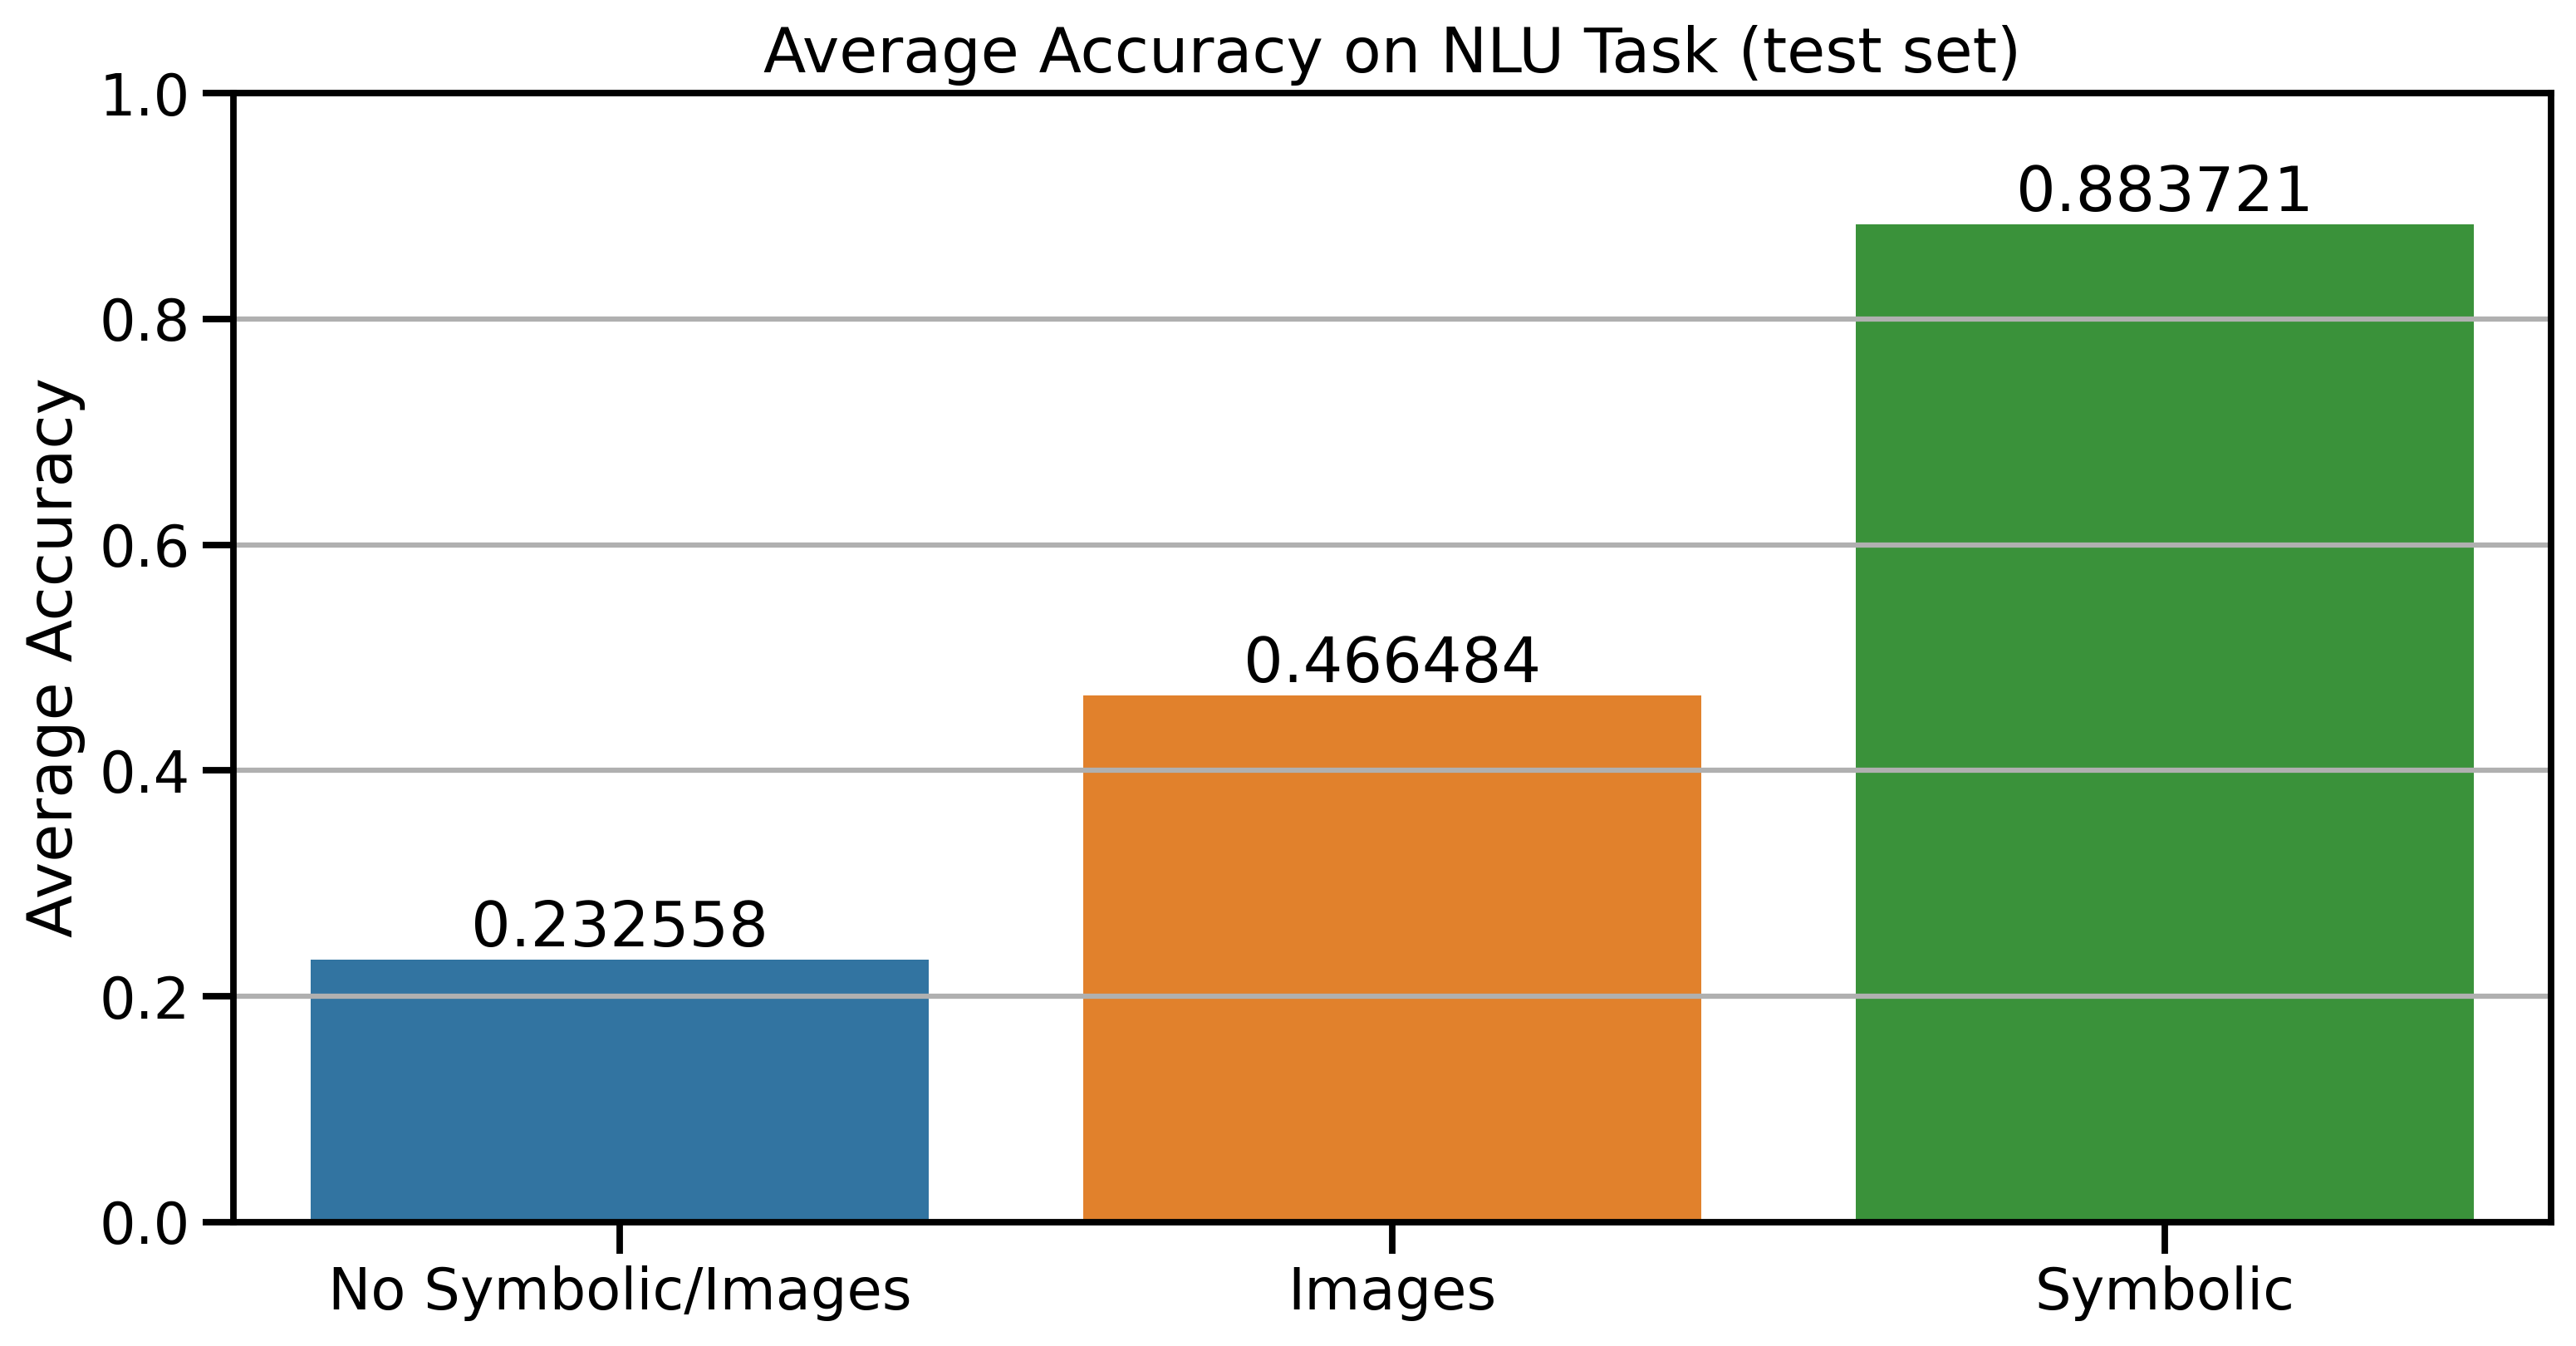

In [166]:
import seaborn as sns
sns.set_context("talk")

plt.figure(figsize=(12, 6), dpi=300)
ax = sns.barplot(data=runs_df[~runs_df.test_accuracy.isna()].sort_values(by="test_accuracy"), x="name", y="test_accuracy")
ax.bar_label(ax.containers[0])
plt.title("Average Accuracy on NLU Task (test set)")
plt.ylim(0,1)
plt.ylabel("Average Accuracy")
plt.xlabel("")
plt.grid(axis="y")
plt.savefig("test_accuracy.png", dpi=300)
plt.show()

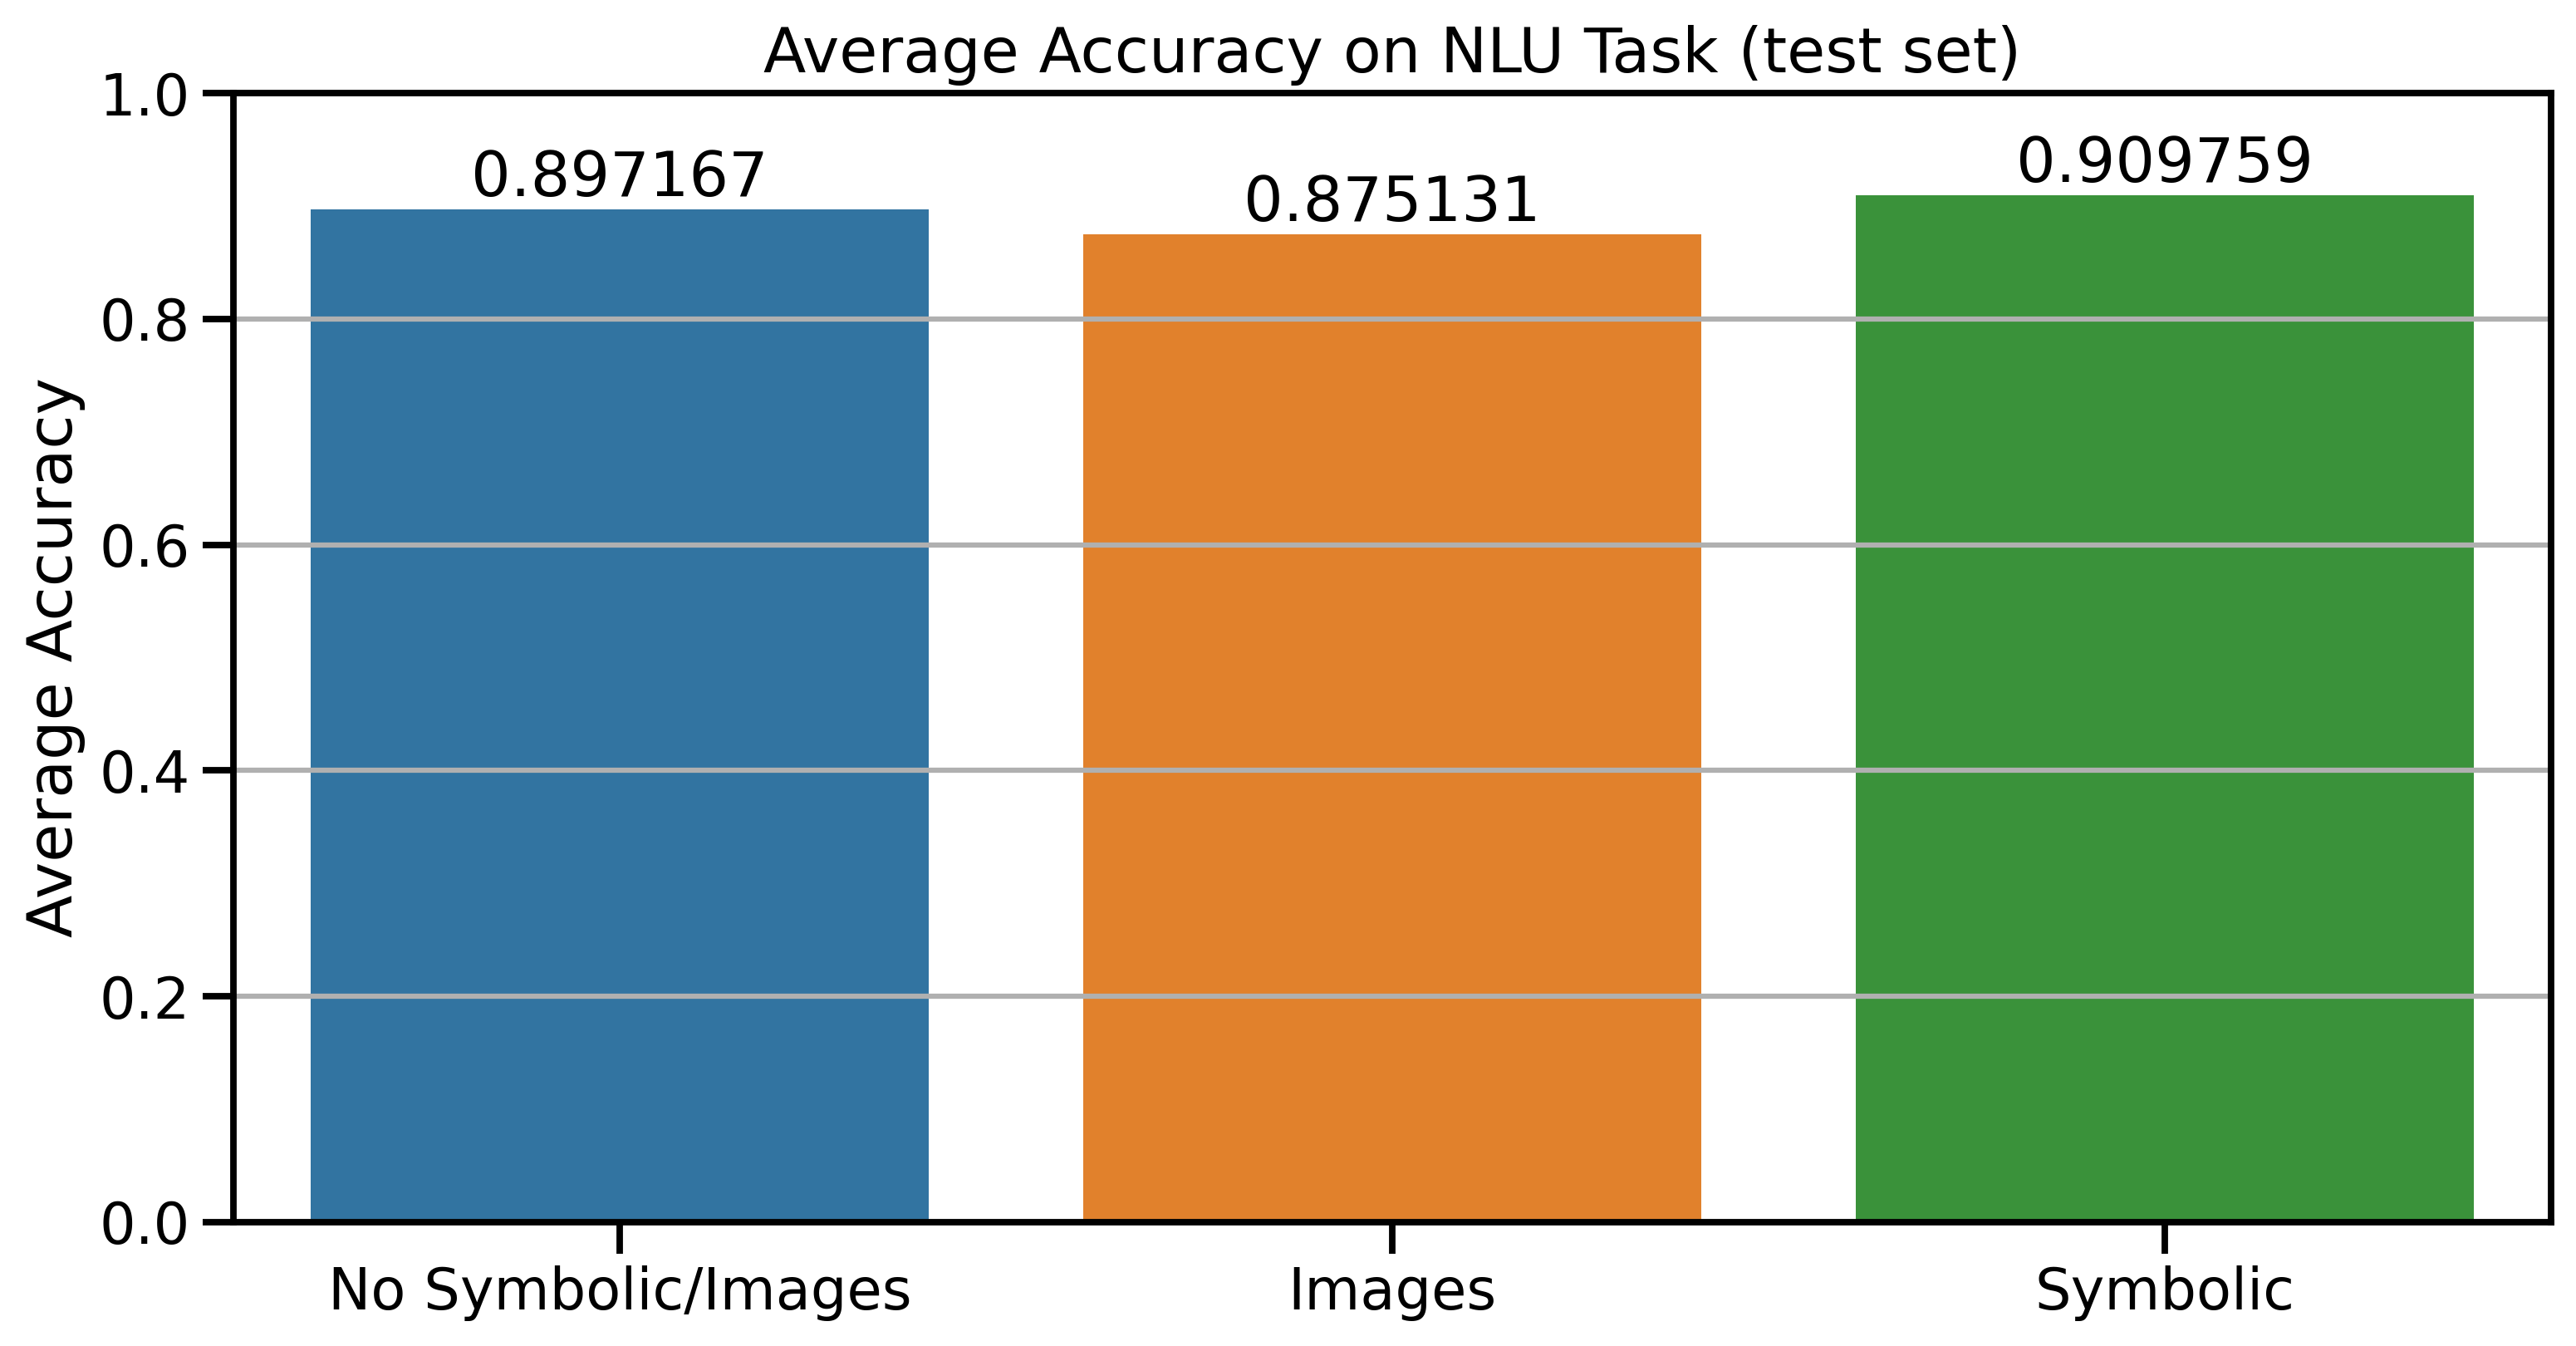

In [167]:
plt.figure(figsize=(12, 6), dpi=300)
ax = sns.barplot(data=runs_df[~runs_df.test_accuracy.isna()].sort_values(by="test_accuracy"), x="name", y="test_diff_accuracy")
ax.bar_label(ax.containers[0])
plt.title("Average Accuracy on NLU Task (test set)")
plt.ylim(0,1)
plt.ylabel("Average Accuracy")
plt.xlabel("")
plt.grid(axis="y")
plt.savefig("test_diff_accuracy.png", dpi=300)
plt.show()

# Generate gif for images

In [273]:
run.name

'images_fuse_42'

In [74]:
from tqdm import tqdm

images = []
for i, row in run.history(keys=["Images"]).iterrows():
    images+= row["Images"]["filenames"]

In [75]:
import matplotlib.pyplot as plt
from matplotlib import animation

image_df = pd.DataFrame({"filename": images})
image_df["step"] = image_df["filename"].apply(lambda x: x.split("_")[1])
image_df["image_id"] = image_df["filename"].apply(lambda x: x.split("_")[2].split(".")[0]).astype(int)

In [109]:
from PIL import Image, ImageDraw

image_ids = image_df.image_id.unique().astype(int)
steps = image_df.step.unique().astype(int)

for image_id in tqdm(image_ids[1:]):
    paths = []
    for step in steps:
        path = f"media/images/Images_{step}_{image_id}.png"
        run.file(path).download(replace=True)
        paths.append(path)

    fp_out = f"{image_id}.gif"
    
    def return_image_with_text(f, s):
        img = Image.open(f)
        ImageDraw.Draw(
        img  # Image
        ).text(
            (0, 0),  # Coordinates
            f'Step {s}',  # Text
            fill=(0, 0, 0)  # Color
        )
        return img

    imgs = (return_image_with_text(f, s) for s, f in enumerate(paths))
    img = next(imgs)  # extract first image from iterator
    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=500, loop=0)

100%|█████████████████████████████████████████████████████████████████| 15/15 [23:15<00:00, 93.02s/it]


In [110]:
run.name

'images_fuse_42'

In [129]:
# runs_df